In [1]:
#dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, Column, Date, Integer, Text, func

In [3]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
conn=engine.connect()
pd.read_sql('SELECT * FROM measurement',conn)

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0
...,...,...,...,...,...
19545,19546,USC00516128,2017-08-19,0.09,71.0
19546,19547,USC00516128,2017-08-20,NaN,78.0
19547,19548,USC00516128,2017-08-21,0.56,76.0
19548,19549,USC00516128,2017-08-22,0.50,76.0


In [5]:
pd.read_sql('SELECT * FROM station',conn)

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
inspector = inspect(engine)

#check the data types for each columns
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Latest Date
latest_date_str=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest_date_str

('2017-08-23',)

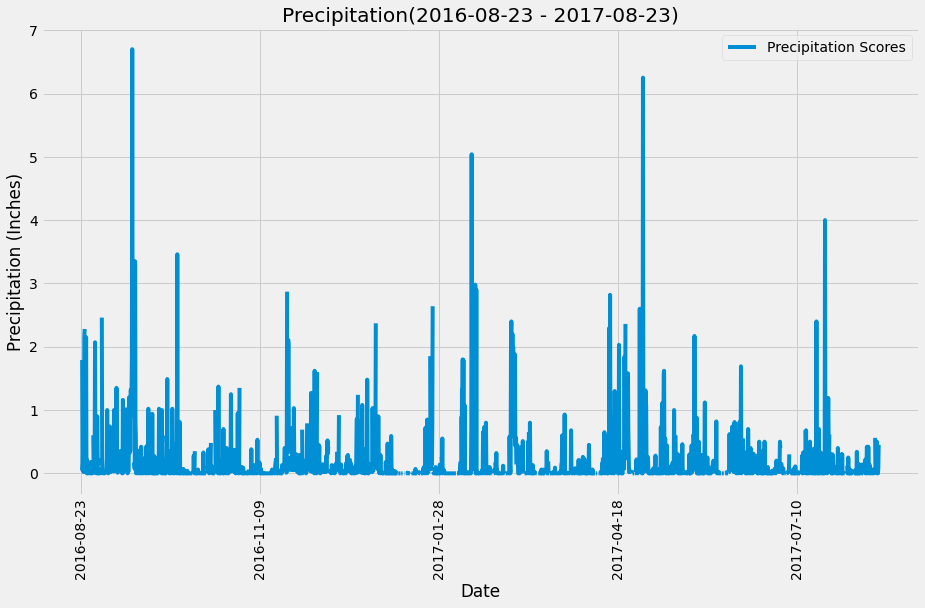

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
latest_date = dt.datetime.strptime(latest_date_str.date, '%Y-%m-%d').date()
latest_date
    
# Calculate the date 1 year ago from the last data point in the database
last_year = latest_date - dt.timedelta(days=365)
last_year

# Perform a query to retrieve the date and precipitation scores
date_prcp=session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= last_year).all()
date_prcp

# Save the query results as a Pandas DataFrame and set the index to the date column
date_prcp_df=pd.DataFrame(date_prcp,columns=['Date','Precipitation Scores'])
date_prcp_df=date_prcp_df.set_index('Date')
date_prcp_df

# Sort the dataframe by date
sorted_date_prcp_df=date_prcp_df.sort_index()
sorted_date_prcp_df

# Use Pandas Plotting with Matplotlib to plot the data
sorted_date_prcp_df.plot(rot=90,figsize=(14,8))
plt.xlabel('Date')
plt.ylabel('Precipitation (Inches)')
plt.title('Precipitation(2016-08-23 - 2017-08-23)')
plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
sorted_date_prcp_df.describe()

,Precipitation Scores
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Climate Analysis

In [14]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9,)]

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_station=session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
active_station
most_active_station=active_station[0][0]

print(f"The most active station is {most_active_station}.")

The most active station is USC00519281.


In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
lowest_temp_most_active_station=session.query(func.min(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()

highest_temp_most_active_station=session.query(func.max(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()

avg_temp_most_active_station=session.query(func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()

print(f"The lowest temperature of the most active station is {lowest_temp_most_active_station[0][0]}.")
print(f"The highest temperature of the most active station is {highest_temp_most_active_station[0][0]}.")
print(f"The average temperature of the most active station is {avg_temp_most_active_station[0][0]}.")

The lowest temperature of the most active station is 54.0.
The highest temperature of the most active station is 85.0.
The average temperature of the most active station is 71.66378066378067.


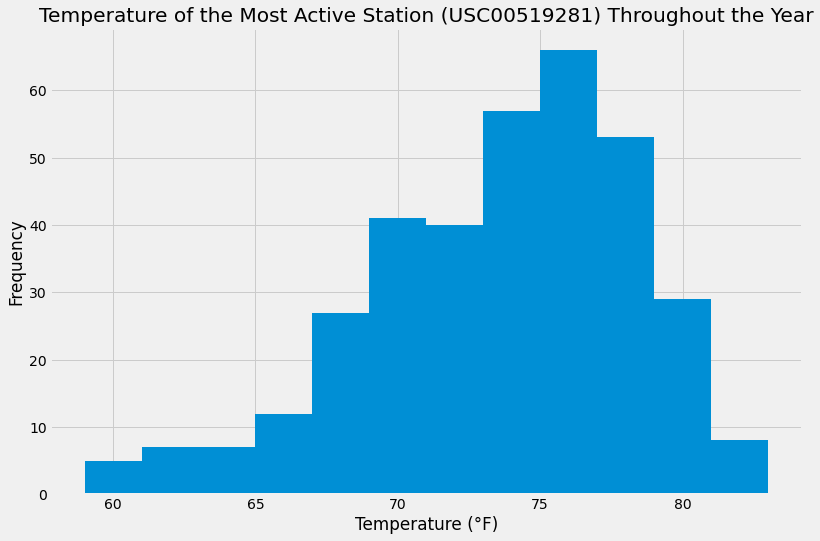

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station_date_tobs=session.query(Measurement.station, Measurement.tobs).\
    filter(Measurement.date >= last_year).\
    filter(Measurement.station == most_active_station).all()
most_active_station_date_tobs

# Save the query results as a Pandas DataFrame and set the index to the Station column
most_active_station_date_tobs_df=pd.DataFrame(most_active_station_date_tobs,columns=['Station','Temperature'])
most_active_station_date_tobs_df=most_active_station_date_tobs_df.set_index('Station')

# Use Pandas Plotting with Matplotlib to plot the data
most_active_station_date_tobs_df.hist(bins=12, figsize=(12, 8))
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title(f'Temperature of the Most Active Station ({most_active_station}) Throughout the Year')
plt.show()

In [18]:
# Close Session
session.close()

## Bonus Challenge Assignment

## Temperature Analysis I

In [19]:
#read the csv file using pandas's read_csv()
measurement_df = pd.read_csv('Resources//hawaii_measurements.csv')
measurement_df

,station,date,prcp,tobs
0,USC00519397,2010-01-01,0.08,65
1,USC00519397,2010-01-02,0.00,63
2,USC00519397,2010-01-03,0.00,74
3,USC00519397,2010-01-04,0.00,76
4,USC00519397,2010-01-06,NaN,73
...,...,...,...,...
19545,USC00516128,2017-08-19,0.09,71
19546,USC00516128,2017-08-20,NaN,78
19547,USC00516128,2017-08-21,0.56,76
19548,USC00516128,2017-08-22,0.50,76


In [20]:
#Identify the data in June at all stations across all available years in the dataset
measurement_june_df = measurement_df[pd.to_datetime(measurement_df['date']).dt.month == 6]
measurement_june_df

,station,date,prcp,tobs
133,USC00519397,2010-06-01,0.00,78
134,USC00519397,2010-06-02,0.01,76
135,USC00519397,2010-06-03,0.00,78
136,USC00519397,2010-06-04,0.00,76
137,USC00519397,2010-06-05,0.00,77
...,...,...,...,...
19492,USC00516128,2017-06-26,0.02,79
19493,USC00516128,2017-06-27,0.10,74
19494,USC00516128,2017-06-28,0.02,74
19495,USC00516128,2017-06-29,0.04,76


In [21]:
#Identify the average temperature in June at all stations across all available years in the dataset
ave_june_tobs=measurement_june_df.groupby('date').mean()
ave_june_tobs=ave_june_tobs['tobs']
ave_june_tobs

date
2010-06-01    73.555556
2010-06-02    74.555556
2010-06-03    74.444444
2010-06-04    72.888889
2010-06-05    76.000000
                ...    
2017-06-26    79.000000
2017-06-27    78.000000
2017-06-28    77.666667
2017-06-29    77.142857
2017-06-30    75.714286
Name: tobs, Length: 240, dtype: float64

In [22]:
#Identify the data in December at all stations across all available years in the dataset
measurement_dec_df = measurement_df[pd.to_datetime(measurement_df['date']).dt.month == 12]
measurement_dec_df

,station,date,prcp,tobs
305,USC00519397,2010-12-01,0.04,76
306,USC00519397,2010-12-03,0.00,74
307,USC00519397,2010-12-04,0.00,74
308,USC00519397,2010-12-06,0.00,64
309,USC00519397,2010-12-07,0.00,64
...,...,...,...,...
19323,USC00516128,2016-12-27,0.14,71
19324,USC00516128,2016-12-28,0.14,71
19325,USC00516128,2016-12-29,1.03,69
19326,USC00516128,2016-12-30,2.37,65


In [23]:
#Identify the average temperature in December at all stations across all available years in the dataset
ave_dec_tobs=measurement_dec_df.groupby('date').mean()
ave_dec_tobs=ave_dec_tobs['tobs']
ave_dec_tobs

date
2010-12-01    73.125000
2010-12-02    72.500000
2010-12-03    71.875000
2010-12-04    74.857143
2010-12-05    71.285714
                ...    
2016-12-27    73.000000
2016-12-28    71.571429
2016-12-29    72.714286
2016-12-30    69.000000
2016-12-31    68.200000
Name: tobs, Length: 217, dtype: float64

The null hypothesis (H0) states that there is no significant difference between the means of the independent samples - average temperature in June across all stations in Hawaii and average temperature in December across all stations in Hawaii

The alternative hypothesis (H1) states that there is a significant difference between the two independednt samples.

In [24]:
stats.ttest_ind(ave_june_tobs, ave_dec_tobs)

Ttest_indResult(statistic=19.320515481847366, pvalue=3.602668975563456e-61)

An unpaired t-test is more suitable to determine the difference in the means than a paired t-test. This is beacuse the temperature in June and the temperature in December are two independent samples which are unrelated to each other.
As the p-value is smaller than 0.05, we can reject the null hypothesis and conclude that there is a statistically significant difference in the average tempeature in June and the average temperature in December.

# Temperature Analysis II

In [25]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [26]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
tobs2014=calc_temps('2014-01-01', '2014-12-31')
min_tobs_2014=tobs2014[0][0]
ave_tobs_2014=tobs2014[0][1]
max_tobs_2014=tobs2014[0][2]

Text(0, 0.5, 'Temperature (°F)')

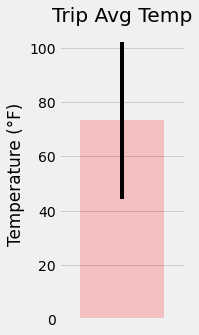

In [27]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(2,5))
plt.bar(0,ave_tobs_2014, width=0.4, color='r', alpha=0.2)
plt.errorbar(0, ave_tobs_2014, yerr = max_tobs_2014 - min_tobs_2014, color='k')
plt.title('Trip Avg Temp')
plt.xticks([])
plt.xlim(-0.3, 0.3)
plt.ylabel('Temperature (°F)')

# Daily Rainfall Average

In [28]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

#read the csv file using pandas's read_csv()
measurement_df = pd.read_csv('Resources//hawaii_measurements.csv')
station_df= pd.read_csv('Resources//hawaii_stations.csv')

start_date = '2014-01-01'
end_date = '2014-01-15'

previous_year_trip_df = measurement_df.loc[(measurement_df['date'] >= start_date) & (measurement_df['date'] <= end_date)]
previous_year_trip_df

daily_rainfall_df=previous_year_trip_df.merge(station_df, how='left', on='station')

daily_rainfall_df.sort_values(by=['prcp'],ascending=False)

,station,date,prcp,tobs,name,latitude,longitude,elevation
100,USC00516128,2014-01-03,2.41,69,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
81,USC00519281,2014-01-14,1.76,73,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
70,USC00519281,2014-01-03,1.62,66,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
17,USC00513117,2014-01-03,1.59,67,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
85,USC00511918,2014-01-03,1.05,73,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
...,...,...,...,...,...,...,...,...
47,USC00517948,2014-01-09,NaN,63,"PEARL CITY, HI US",21.39340,-157.97510,11.9
48,USC00518838,2014-01-06,NaN,71,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
49,USC00518838,2014-01-08,NaN,65,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
50,USC00518838,2014-01-10,NaN,67,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6


In [29]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [30]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2015-01-01'
end_date = '2015-01-15'

# Use the start and end date to create a range of dates
start = dt.datetime.strptime(start_date, '%Y-%m-%d')
end = dt.datetime.strptime(end_date, '%Y-%m-%d')
days = (end - start).days
date_list = [start + dt.timedelta(days=x) for x in range(days+1)]
date_list

# Stip off the year and save a list of %m-%d strings
month_date_list = [date.strftime('%m-%d') for date in date_list]
month_date_list

# Loop through the list of %m-%d strings and calculate the normals for each date
normals=[]

for month_date in range(len(month_date_list)):
    dict={}
    dict['date'] = month_date_list[month_date]
    dict['tmin'] = daily_normals(month_date_list[month_date])[0][0]
    dict['tavg'] = daily_normals(month_date_list[month_date])[0][1]
    dict['tmax'] = daily_normals(month_date_list[month_date])[0][2]
    normals.append(dict)
    
normals

[{'date': '01-01', 'tmin': 62.0, 'tavg': 69.15384615384616, 'tmax': 77.0},
 {'date': '01-02', 'tmin': 60.0, 'tavg': 69.39622641509433, 'tmax': 77.0},
 {'date': '01-03', 'tmin': 62.0, 'tavg': 68.9090909090909, 'tmax': 77.0},
 {'date': '01-04', 'tmin': 58.0, 'tavg': 70.0, 'tmax': 76.0},
 {'date': '01-05', 'tmin': 56.0, 'tavg': 67.96428571428571, 'tmax': 76.0},
 {'date': '01-06', 'tmin': 61.0, 'tavg': 68.96491228070175, 'tmax': 76.0},
 {'date': '01-07', 'tmin': 57.0, 'tavg': 68.54385964912281, 'tmax': 76.0},
 {'date': '01-08', 'tmin': 57.0, 'tavg': 67.16071428571429, 'tmax': 75.0},
 {'date': '01-09', 'tmin': 58.0, 'tavg': 67.9298245614035, 'tmax': 78.0},
 {'date': '01-10', 'tmin': 62.0, 'tavg': 69.74137931034483, 'tmax': 77.0},
 {'date': '01-11', 'tmin': 57.0, 'tavg': 67.3103448275862, 'tmax': 78.0},
 {'date': '01-12', 'tmin': 57.0, 'tavg': 67.4074074074074, 'tmax': 81.0},
 {'date': '01-13', 'tmin': 57.0, 'tavg': 67.25454545454545, 'tmax': 77.0},
 {'date': '01-14', 'tmin': 58.0, 'tavg': 6

In [31]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
date_df = pd.DataFrame(normals).set_index('date')
date_df

,tmin,tavg,tmax
date,,,
01-01,62.0,69.153846,77.0
01-02,60.0,69.396226,77.0
01-03,62.0,68.909091,77.0
01-04,58.0,70.000000,76.0
01-05,56.0,67.964286,76.0
01-06,61.0,68.964912,76.0
01-07,57.0,68.543860,76.0
01-08,57.0,67.160714,75.0
01-09,58.0,67.929825,78.0


Text(0, 0.5, 'Temperature (°F)')

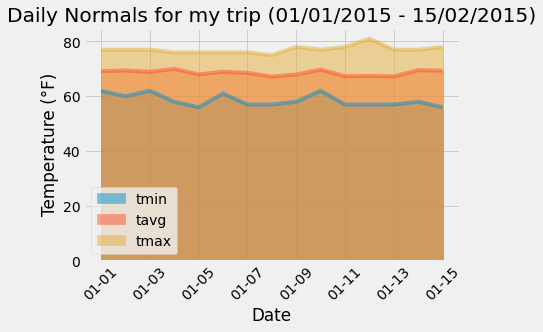

In [32]:
# Plot the daily normals as an area plot with `stacked=False`
date_df.plot.area(stacked=False, rot=45)
plt.title('Daily Normals for my trip (01/01/2015 - 15/02/2015)')
plt.xlabel('Date')
plt.ylabel('Temperature (°F)')